### Libraries, tools, data locations

In [1]:
# because we like pretty code
%load_ext jupyter_black

In [2]:
import datetime as dt

import warnings
from pathlib import Path
from typing import List, Union

import holidays

# Plotting
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Living on the edge...
warnings.filterwarnings("ignore")

# scientific libraries/tools
from random import randint
from scipy import signal

# for model evaluation, split data into training and testing; use group shuffle split to prevent memorization
from sklearn.model_selection import GroupShuffleSplit
from xgboost import XGBClassifier

# data location
DATA_DIR = Path("/Users/lindseygulden/dev/leg-up/projects/amperon/data")

PROB_FILENAME = "probability_estimates.csv"
LOAD_FILENAME = "load_hist_data.csv"
WEATHER_FILENAME = "weather_data.csv"

### Fit-for-purpose functions

In [3]:
# feature engineering functions


def season(m: int):
    """Assigns season name to integer month of year"""
    if m in [12, 1, 2]:
        return "winter"
    if m in [3, 4, 5]:
        return "spring"
    if m in [6, 7, 8]:
        return "summer"
    return "fall"


def am_pm_heating_hours(date_df, threshold_f: float = 65):
    am = np.sum(
        [
            max(0, t - threshold_f)
            for t, h in zip(date_df[21], date_df["hour"])
            if h < 13
        ]
    )
    pm = np.sum(
        [
            max(0, t - threshold_f)
            for t, h in zip(date_df[21], date_df["hour"])
            if h > 12
        ]
    )
    return am, pm


def am_pm_cooling_hours(date_df, threshold_f: float = 55):
    am = np.sum(
        [
            max(0, threshold_f - t)
            for t, h in zip(date_df[21], date_df["hour"])
            if h < 13
        ]
    )
    pm = np.sum(
        [
            max(0, threshold_f - t)
            for t, h in zip(date_df[21], date_df["hour"])
            if h > 12
        ]
    )
    return am, pm


# functions for model training and evaluation
def hour_score(probability: float, actual: float):
    """Compute the specified score for each hour"""
    return (probability - actual) ** 2


def amperon_score(
    probabilities: Union[pd.Series, List[float]], actuals: Union[pd.Series, List[float]]
):
    """Compute the total run score for a list of probabiliteis and the list of actuals"""
    return np.sum(hour_score(p, a) for p, a in zip(probabilities, actuals))


def group_train_test_split(
    X_df: pd.DataFrame,
    y_df: pd.DataFrame,
    group: List["str"],
    test_size: float = 0.3,
    random_state: int = 42,
):
    """Splits data into training and test sets; ensures all members of specified group are in test OR train, not both"""
    Xy = Xy_df.merge(y_df, right_index=True, left_index=True)
    splitter = GroupShuffleSplit(test_size=0.2, random_state=42, n_splits=2)
    split = splitter.split(Xy_df, groups=Xy_df["date"])
    train_idxs, test_idxs = next(split)
    # mimic train_test_split return order
    return (
        X_df.iloc[train_idxs],
        X_df.iloc[test_idxs],
        y_df.iloc[train_idxs],
        y_df.iloc[test_idxs],
    )

### Load data, lightly process

In [4]:
# desired format for output
prob_df = pd.read_csv(DATA_DIR / Path(PROB_FILENAME))  # Formatted output dataframe
prob_df.columns = [x.lower().replace(" ", "_") for x in prob_df.columns.values]
prob_df["dt_date"] = [dt.datetime.strptime(x, "%m/%d/%Y") for x in prob_df.date]
# hourly electrical load
load_df = pd.read_csv(DATA_DIR / Path(LOAD_FILENAME))
load_df.columns = [x.lower().replace(" ", "_") for x in load_df.columns.values]

# characterize the dates in various ways
load_df["date"] = [dt.datetime.strptime(x, "%m/%d/%Y") for x in load_df.date]
load_df["datetime"] = [
    dt.datetime.combine(d, dt.time(h - 1, 0))
    for d, h in zip(load_df.date, load_df.hour)
]


# generate modeling target (whether the load for a given hour is the maximum daily load)
peak_load_df = load_df[["load", "date"]].groupby("date").max().reset_index()
peak_load_df.rename(columns={"load": "daily_peak_load"}, inplace=True)
load_df = load_df.merge(peak_load_df, on="date")
load_df["is_max"] = [
    int(x == p) for x, p in zip(load_df.load, load_df.daily_peak_load)
]  # <--- modeling target

# hourly temperature data for 28 stations (relation of each station to load not made clear)
weather_df = pd.read_csv(DATA_DIR / Path(WEATHER_FILENAME))
weather_df.columns = [x.lower().replace(" ", "_") for x in weather_df.columns.values]
# remove duplicate entries
weather_df.drop_duplicates(inplace=True)
# average across duplicate values for a single station, date, and hour
weather_df = (
    weather_df[["date", "hour", "station_id", "temperature"]]
    .groupby(["date", "hour", "station_id"])
    .mean()
    .reset_index()
)

# convert to datetime
weather_df["date"] = [dt.datetime.strptime(x, "%m/%d/%Y") for x in weather_df.date]
weather_df["datetime"] = [
    dt.datetime.combine(d, dt.time(h - 1, 0))
    for d, h in zip(weather_df.date, weather_df.hour)
]

# pivot such that each station's temperature values form a column
weather_df = (
    weather_df[["date", "datetime", "hour", "station_id", "temperature"]]
    .pivot(
        index=["date", "datetime", "hour"], values="temperature", columns="station_id"
    )
    .reset_index()
)

# characterize the dates in various ways
weather_df["month"] = [int(x.month) for x in weather_df.date]
weather_df["day_of_week"] = [int(x.isoweekday()) for x in weather_df.date]
weather_df["is_weekday"] = [int(d < 6) for d in weather_df.day_of_week]
weather_df["is_weekend_or_holiday"] = [
    int((x in holidays.US()) or (wd == 0))
    for x, wd in zip(weather_df.date, weather_df.is_weekday)
]
weather_df["year"] = [int(x.year) for x in weather_df.date]
weather_df["season"] = [season(m) for m in weather_df.month]

### EDA, feature engineering, data massage, etc.

#### Plot load and temperature data

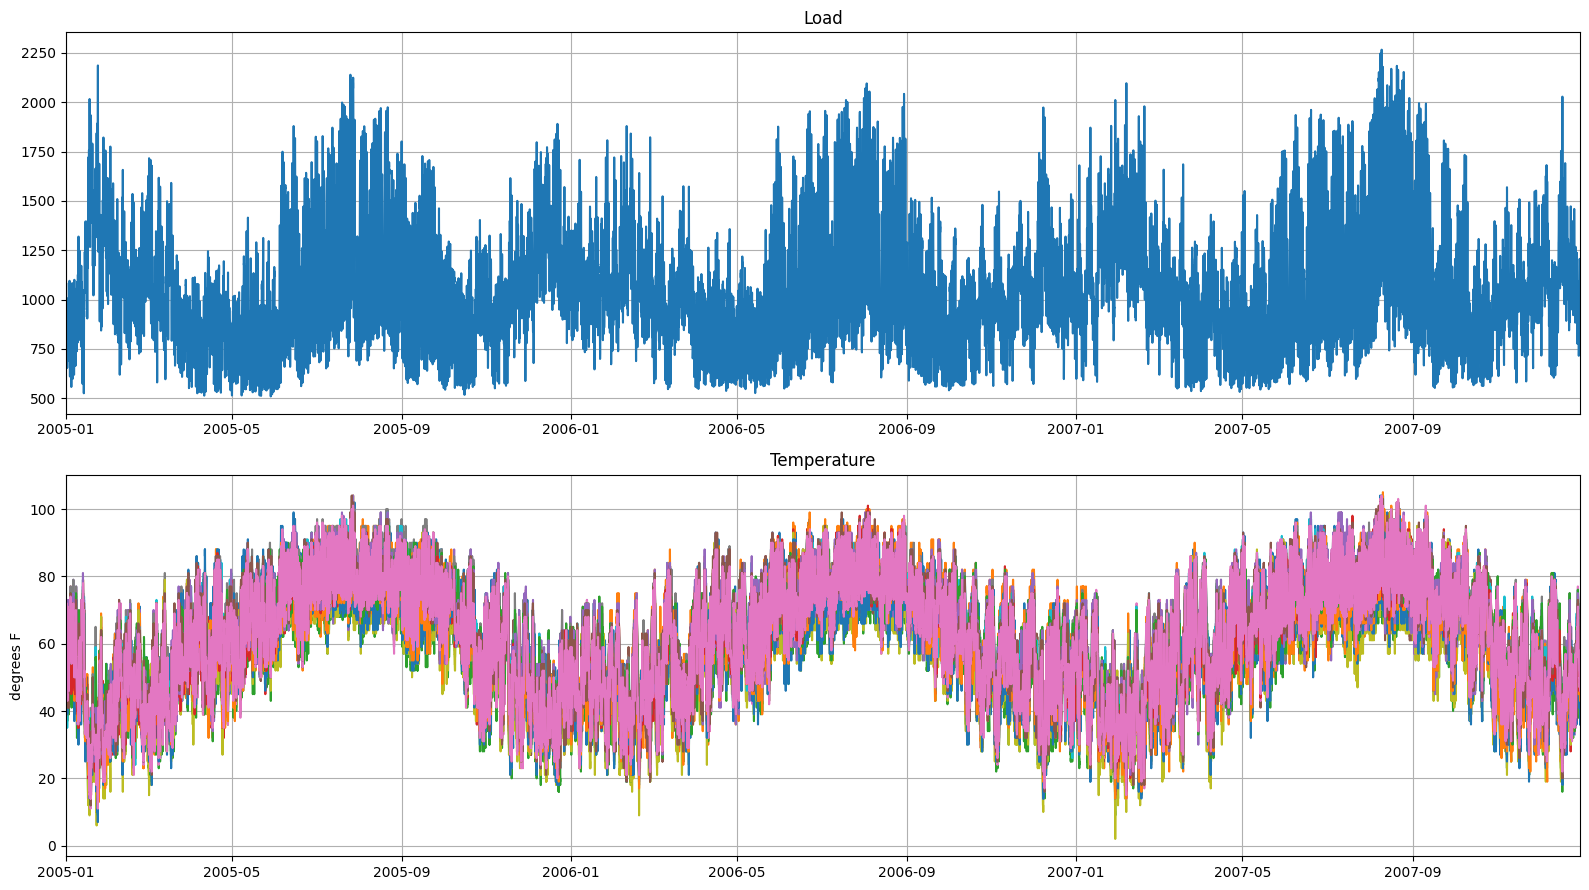

In [5]:
fig, _ = plt.subplots(2, 1, figsize=(16, 9))

# plot load
plt.subplot(2, 1, 1)
plt.plot(load_df["datetime"], load_df["load"])
plt.xlim([dt.datetime(2005, 1, 1), dt.datetime(2007, 12, 31)])
plt.grid()
plt.title("Load")

# plot all stations' temperatures
plt.subplot(2, 1, 2)
plt.plot(weather_df["datetime"], weather_df[list(range(1, 28))])
plt.xlim([dt.datetime(2005, 1, 1), dt.datetime(2007, 12, 31)])
plt.grid()
plt.title("Temperature")
plt.ylabel("degrees F")
fig.tight_layout()

#### Look at pattern of daily peak load (using Station 1 as an example)

<Axes: xlabel='min_temp', ylabel='daily_peak_load'>

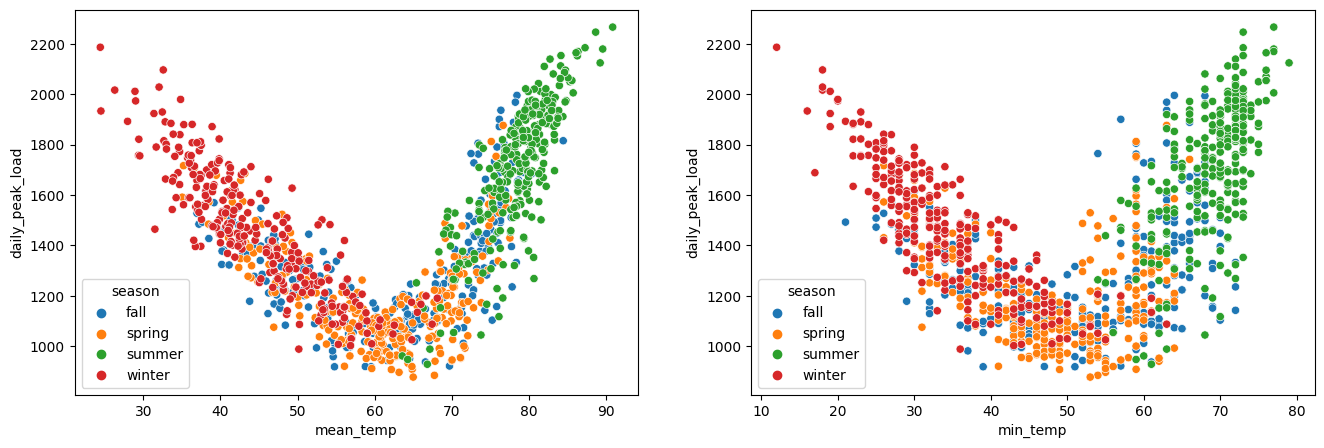

In [6]:
# combine daily-scale variables for EDA

peak_load_df = peak_load_df.merge(
    load_df[["date", "hour"]].loc[load_df.is_max == 1],
    on=["date"],
)
daily_stats_df = (
    weather_df[["season", "date", 1]]
    .groupby(["season", "date"])
    .agg({1: ["mean", "min"]})
    .reset_index()
)
daily_stats_df.columns = ["season", "date", "mean_temp", "min_temp"]
daily_stats_df = daily_stats_df.merge(peak_load_df, on="date")
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.scatterplot(
    daily_stats_df, y="daily_peak_load", x="mean_temp", hue="season", ax=axes[0]
)
sns.scatterplot(
    daily_stats_df, y="daily_peak_load", x="min_temp", hue="season", ax=axes[1]
)

#### ^^ Observations regarding pattern of peak daily load
- Non-linear relationship between temperature and peak load
- 60 degrees F is the approximate location of the 'V'/inflection point


### Figures relating hour of the peak daily load to various characteristics

<Axes: xlabel='is_weekend_or_holiday', ylabel='hour'>

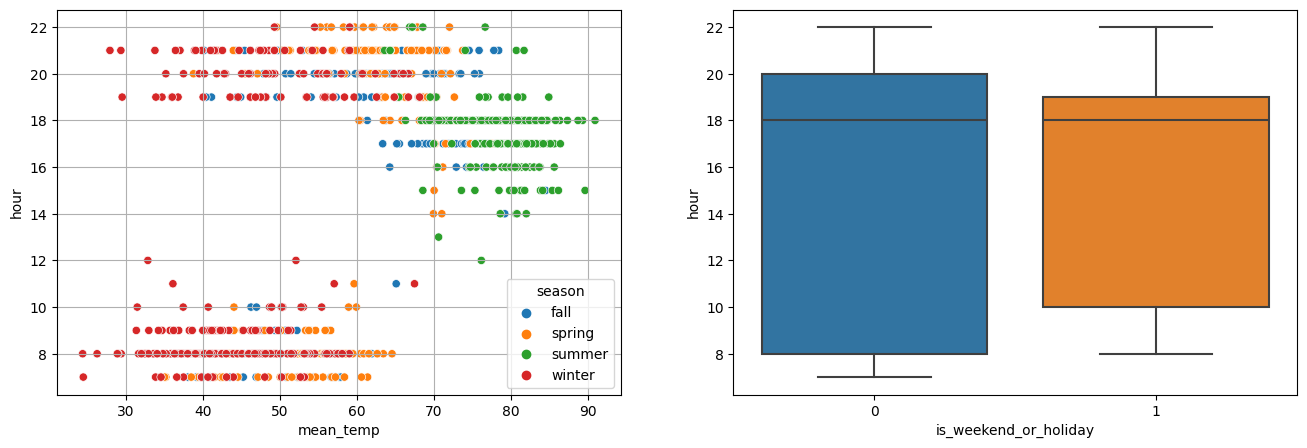

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
sns.scatterplot(daily_stats_df, y="hour", x="mean_temp", hue="season", ax=axes[0])
axes[0].grid()
daily_stats_df["is_weekend_or_holiday"] = [
    int((x in holidays.US()) or (int(d.isoweekday()) > 5))
    for x, d in zip(daily_stats_df.date, daily_stats_df.date)
]
sns.boxplot(daily_stats_df, y="hour", x="is_weekend_or_holiday", ax=axes[1])

#### ^^ Observations regarding hour of peak daily load
- There are two clusters of peak usage: mid-morning hours and late-afternoon/evening hours
- Summer peaks almost always occur in the late afternoon
- Winter peaks tend to occur in the morning
- Bridge seasons of spring and fall have split populations: I'm guessing this is b/c of daily temperature (and other weather variable) distributions
- On weekends and holidays there are few peaks in early-morning hours


#### Compute cooling hours (below 55) and heating hours (above 65) in morning and evening

In [8]:
cooling_df = weather_df[["date", "hour", 21]].groupby("date").apply(am_pm_cooling_hours)
heating_df = weather_df[["date", "hour", 21]].groupby("date").apply(am_pm_heating_hours)

weather_df = weather_df.merge(
    pd.DataFrame(
        cooling_df.to_list(),
        columns=["am_cooling_hours", "pm_cooling_hours"],
        index=cooling_df.index,
    ),
    left_on="date",
    right_index=True,
)
weather_df = weather_df.merge(
    pd.DataFrame(
        heating_df.to_list(),
        columns=["am_heating_hours", "pm_heating_hours"],
        index=heating_df.index,
    ),
    left_on="date",
    right_index=True,
)
weather_df["pm_more_cooling"] = [
    int(p > a) for p, a in zip(weather_df.pm_cooling_hours, weather_df.am_cooling_hours)
]
weather_df["pm_more_heating"] = [
    int(p > a) for p, a in zip(weather_df.pm_heating_hours, weather_df.am_heating_hours)
]
weather_df["pm_less_am_cooling"] = [
    p - a for p, a in zip(weather_df.pm_cooling_hours, weather_df.am_cooling_hours)
]
weather_df["pm_less_am_heating"] = [
    p - a for p, a in zip(weather_df.pm_heating_hours, weather_df.am_heating_hours)
]
# digest_for_daily_stats to weather df
daily_stats_df = daily_stats_df.merge(
    weather_df[
        [
            "date",
            "pm_more_cooling",
            "pm_more_heating",
            "am_heating_hours",
            "pm_heating_hours",
            "pm_less_am_cooling",
            "pm_less_am_heating",
        ]
    ]
    .copy(deep=True)
    .groupby("date")
    .first()
    .reset_index(),
    on="date",
)

<Axes: xlabel='mean_temp', ylabel='hour'>

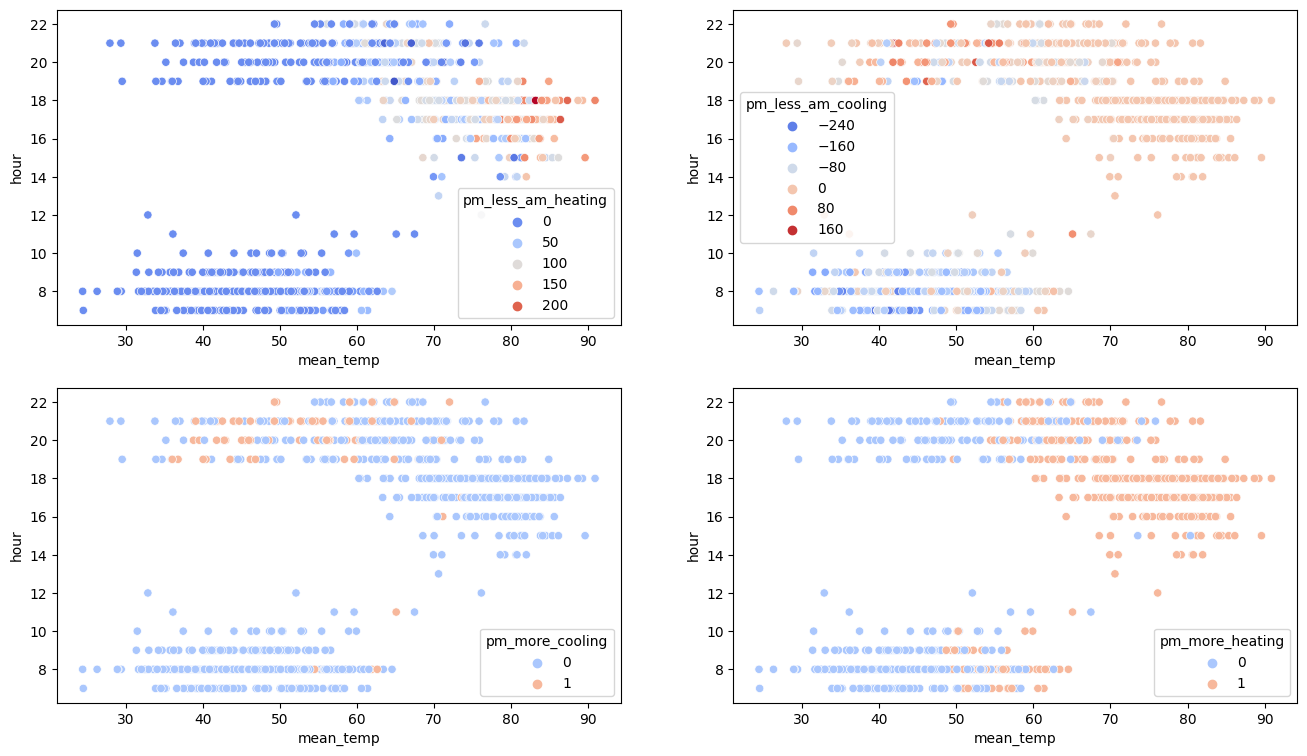

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 9))
sns.scatterplot(
    daily_stats_df,
    y="hour",
    x="mean_temp",
    hue="pm_less_am_heating",
    palette="coolwarm",
    ax=axes[0][0],
)
sns.scatterplot(
    daily_stats_df,
    y="hour",
    x="mean_temp",
    hue="pm_less_am_cooling",
    palette="coolwarm",
    ax=axes[0][1],
)
sns.scatterplot(
    daily_stats_df,
    y="hour",
    x="mean_temp",
    hue="pm_more_cooling",
    palette="coolwarm",
    ax=axes[1][0],
)
sns.scatterplot(
    daily_stats_df,
    y="hour",
    x="mean_temp",
    hue="pm_more_heating",
    palette="coolwarm",
    ax=axes[1][1],
)

### Use figure to identify 'flip flop season' (when peak usage can occur in morning or evening)


(6.0, 24.0)

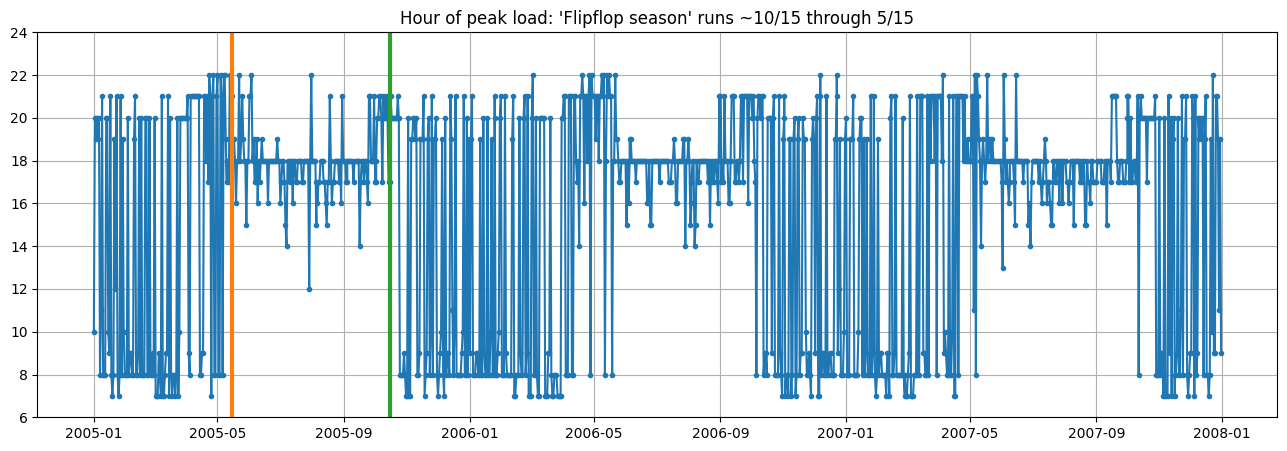

In [10]:
fig, _ = plt.subplots(figsize=(16, 5))
plt.plot(peak_load_df.date, peak_load_df.hour, ".-")
plt.grid()
plt.title("Hour of peak load: 'Flipflop season' runs ~10/15 through 5/15")
plt.plot([dt.datetime(2005, 5, 15)] * 2, [6, 24], lw=3)
plt.plot([dt.datetime(2005, 10, 15)] * 2, [6, 24], lw=3)
plt.ylim([6, 24])

#### Observations regarding 'flip flop season'
- 'Flipflop season', in which peak usage can occur either in the AM or PM runs ~10/15 through 5/15 each year

#### Create features that identify whether an hour is 'flip flop season', the bridge seasons (spring/fall), or winter

In [11]:
weather_df["is_flipflop_season"] = [
    0 if (d > dt.datetime(y, 5, 15)) and (d < dt.datetime(y, 10, 15)) else 1
    for d, y in zip(weather_df.date, weather_df.year)
]
weather_df["is_winter"] = [int(x == "winter") for x in weather_df.season]
weather_df["is_bridge"] = [int(x in ["fall", "spring"]) for x in weather_df.season]

### How are temperature data from different stations related correlated/shifted in time?

#### For each station, compute lag at which correlation is greatest

Text(0.5, 1.0, 'Hour lag with maximum correlation between stations')

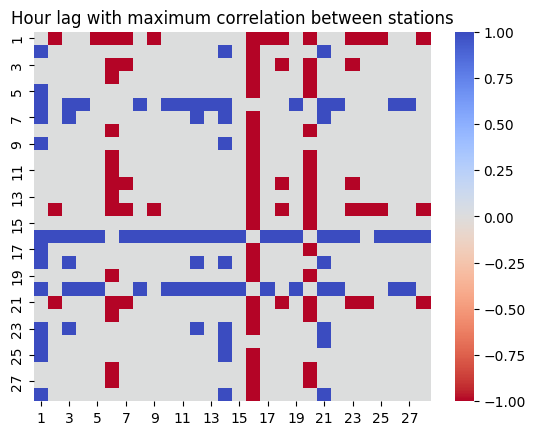

In [12]:
df_list = []
for s1 in range(1, 29):
    index_list = []
    result_list = []
    for s2 in range(1, 29):
        station1 = weather_df.loc[:, s1]
        station1 = station1 - np.mean(station1)
        station2 = weather_df.loc[:, s2]
        station2 = station2 - np.mean(station2)
        # find correlation between station1 and station2 time series, adjusting lag
        correlation = signal.correlate(station1, station2, mode="full")
        lags = signal.correlation_lags(len(station1), len(station2), mode="full")
        # find lag with the maximum absolute value of the correlation
        lag = lags[np.argmax(abs(correlation))]
        index_list.append(s2)
        result_list.append(lag)
    df_list.append(pd.DataFrame({s1: result_list}, index=index_list))

# plot heatmap of maximum-absolute-value-of-correlation lag value
sns.heatmap(data=pd.concat(df_list, axis=1), cmap="coolwarm_r")
plt.title("Hour lag with maximum correlation between stations")

#### For each station, compute correlation between temperature and load at different hourly lags

In [13]:
def corr_bw_temp_and_load(weather_and_load_df: pd.DataFrame):
    """Finds correlation between hourly temperature and load for each station"""
    lag_dict = {}
    correlation_list = []
    lag_list = []
    load_series = weather_and_load_df.loc[:, "load"]
    load_series = load_series - np.mean(load_series)
    for s in list(range(1, 29)):
        station = weather_and_load_df.loc[:, s]
        station = station - np.mean(station)
        correlation = signal.correlate(load_series, station, mode="full")
        lags = signal.correlation_lags(len(load_series), len(station), mode="full")
        # lags = signal.correlation_lags(len(load_series),len(station), mode="full")
        lag = lags[np.argmax(abs(correlation))]
        lag_list.append(pd.DataFrame({s: correlation}, index=lags))
        correlation_list.append(pd.DataFrame({s: correlation}))

    # subset within one year
    lag_corr_with_load_df = pd.concat(lag_list, axis=1)
    lag_corr_with_load_df["lag_days"] = [x / 24 for x in lag_corr_with_load_df.index]
    lag_corr_with_load_df = lag_corr_with_load_df.loc[list(range(-8800, 8800)), :]

    correlations_df = lag_corr_with_load_df.loc[list(range(-50, 50)), :] / 1e7
    return correlations_df

In [14]:
correlations_df = corr_bw_temp_and_load(weather_df.merge(load_df, on=["datetime"]))

In [15]:
# shift_lags=correlations_df.loc[list(range(-5,6)),list(range(1,29))].idxmax()
# weather_adjusted_df=weather_df.copy(deep=True)
# for i,lag in shift_lags.items():
#    weather_adjusted_df[i]=weather_adjusted_df[i].shift(lag).fillna(0)
# correlations_adjusted_df=corr_bw_temp_and_load(weather_adjusted_df.merge(load_df,on=['datetime']))

Text(0.5, 25.722222222222214, 'Hourly lag')

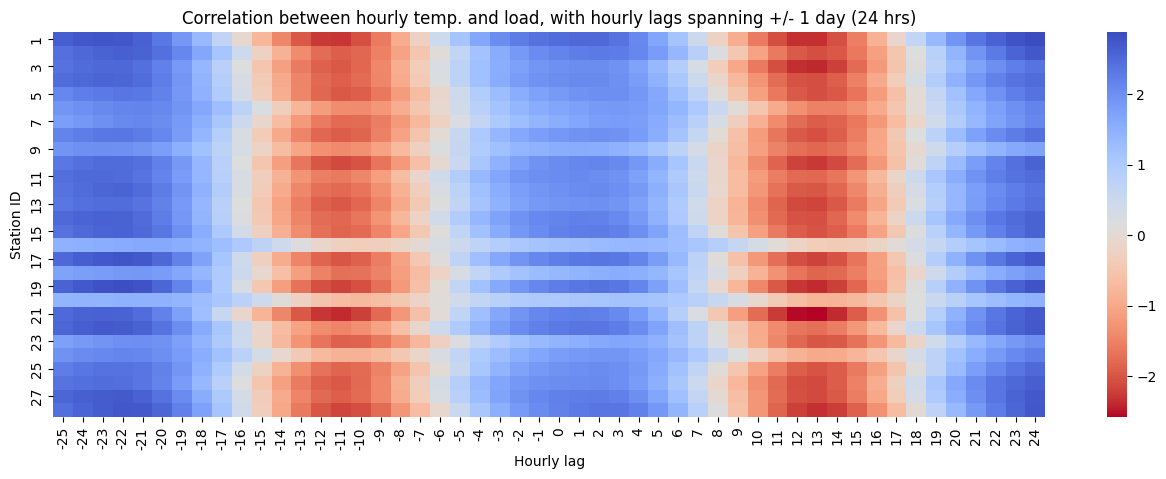

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(16, 5))
plt.subplot(1, 1, 1)
sns.heatmap(
    data=correlations_df.loc[list(range(-25, 25)), list(range(1, 29))].T,
    cmap="coolwarm_r",
)
plt.title(
    "Correlation between hourly temp. and load, with hourly lags spanning +/- 1 day (24 hrs)"
)
plt.ylabel("Station ID")
plt.xlabel("Hourly lag")
# plt.subplot(2,1,2)
# sns.heatmap(data=correlations_adjusted_df.loc[:,list(range(1,29))].T,cmap='coolwarm_r')
# plt.title('Hourly correlation +/- 1 day (24 hrs)')

Text(0.5, 1.0, 'Peak negative correlation')

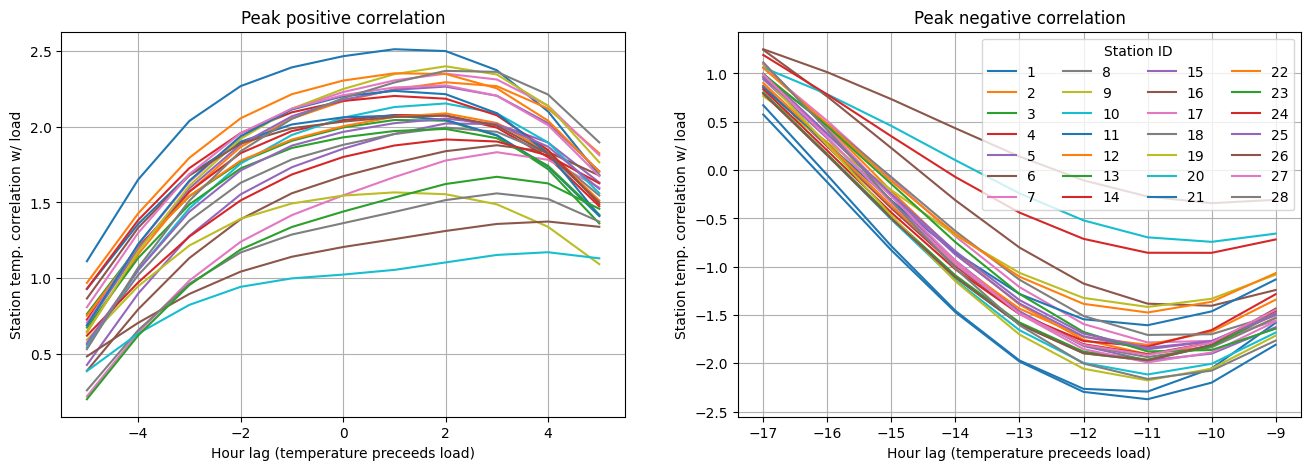

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plt.subplot(1, 2, 1)

ax = plt.plot(correlations_df.loc[list(range(-5, 6)), list(range(1, 29))])
plt.ylabel("Station temp. correlation w/ load")
plt.xlabel("Hour lag (temperature preceeds load)")
plt.grid()
plt.title("Peak positive correlation")
plt.subplot(1, 2, 2)

ax = plt.plot(
    correlations_df.loc[list(range(-17, -8)), list(range(1, 29))],
    label=list(range(1, 29)),
)
plt.grid()
plt.xlabel("Hour lag (temperature preceeds load)")
plt.legend(ncol=4, title="Station ID")
plt.ylabel("Station temp. correlation w/ load")
plt.title("Peak negative correlation")

### Which stations have the most consistently strong correlations with load?

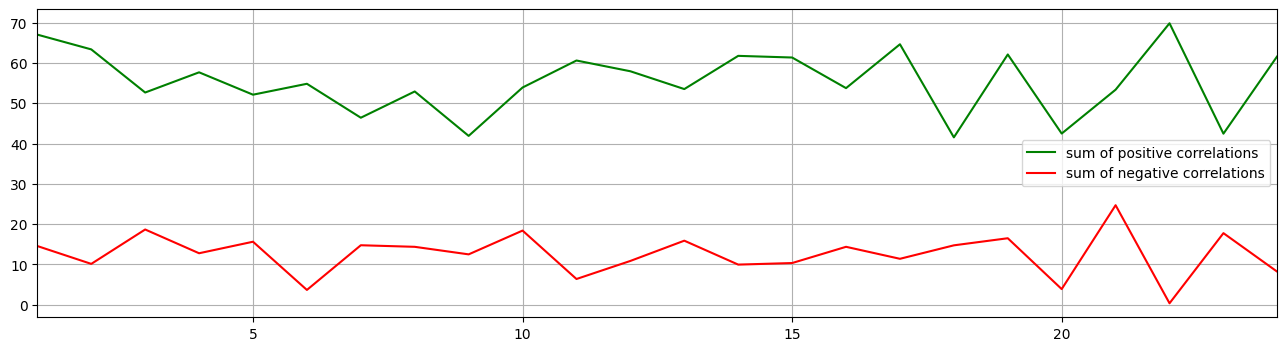

In [18]:
fig, _ = plt.subplots(figsize=(16, 4))
hours = [24]  # ,48,168]
colors = ["b", "r", "tab:green", "k"]
for i, hour in enumerate(hours):
    plt.plot(
        correlations_df.loc[list(range(-1 * hour, hour)), list(range(1, 29))].apply(
            lambda x: np.sum((x + abs(x) / 2))
        ),
        color="g",
        label="sum of positive correlations",
    )
    plt.plot(
        correlations_df.loc[list(range(-1 * hour, hour)), list(range(1, 29))].apply(
            lambda x: abs(np.sum((x - abs(x) / 2)))
        ),
        color="r",
        label="sum of negative correlations",
    )
plt.legend()
plt.xlim([1, 24])
plt.grid()

#### ^^ Observations
- Stations 1, 17,19,21,22 have high information content within 1 day of the present hour

In [19]:
# compute a few time-shift variables based on information content and maximum-info lag
weather_df["22_shift24"] = weather_df[22].shift(24).fillna(0)
weather_df["21_shift12"] = weather_df[21].shift(12).fillna(0)
weather_df["1_shift12"] = weather_df[1].shift(11).fillna(0)
weather_df["21_shift4"] = weather_df[21].shift(4).fillna(0)
weather_df["21_shift2"] = weather_df[21].shift(2).fillna(0)
weather_df["21_shift14"] = weather_df[21].shift(14).fillna(0)

### Represent hours as distance (in time) from min and max hourly temperatures
For 'information-rich' stations (that have high correlations with peak load), compute each hours' distance (in time) from the day's 
minimum and maximum temperatures

In [20]:
weather_df.year.value_counts()

year
2008    8783
2005    8759
2006    8759
2007    8759
Name: count, dtype: int64

In [21]:
idx_min_df = weather_df[["date", 1, 17, 19, 21, 22]].groupby("date").idxmin()
idx_max_df = weather_df[["date", 1, 17, 19, 21, 22]].groupby("date").idxmax()
for s in [1, 17, 19, 21, 22]:
    idx_min_df[f"s{s}_min_temp_hour"] = list(weather_df.iloc[idx_min_df[s], :]["hour"])
    idx_max_df[f"s{s}_max_temp_hour"] = list(weather_df.iloc[idx_max_df[s], :]["hour"])
idx_min_df.drop([1, 17, 19, 21, 22], axis=1, inplace=True)
idx_max_df.drop([1, 17, 19, 21, 22], axis=1, inplace=True)
min_max_df = idx_min_df.merge(idx_max_df, right_index=True, left_index=True)
weather_df = weather_df.merge(min_max_df, left_on="date", right_index=True)

## Model training/testing

### Build decision-tree classifier
#### Why a tree-based classifier?
- Tree-based classifiers handle unbalanced classification datasets fairly well
- Inherent in the ensemble of trees is a way to estimate classification probability (fraction of trees that assign a data point to a class is a direct estimate classification probability )

In [22]:
# List of possible features to use from ^^
X_vars = [
    "month",
    "hour",
    "is_weekday",
    1,
    19,
    17,
    21,
    22,
    "22_shift24",
    "21_shift12",
    "is_flipflop_season",
    "is_winter",
    "is_bridge",
    "pm_more_cooling",
    "pm_less_am_cooling",
    "pm_less_am_heating",
    "21_shift2",
    "s1_min_temp_hour",
    "s17_min_temp_hour",
    "s19_min_temp_hour",
    "s21_min_temp_hour",
    "s22_min_temp_hour",
    "s1_max_temp_hour",
    "s17_max_temp_hour",
    "s19_max_temp_hour",
    "s21_max_temp_hour",
    "s22_max_temp_hour",
]

### Greedy-ish feature selection with a hint of random

#### There's no guarantee that a day's hours' probabilities will sum to 1. Make a function to do that

In [23]:
def scale_raw_probabilities(raw_pred, df_with_pred_indexes, df_with_date):
    """Ensures that the sum of probabilities for a day is 1"""
    df_with_pred_indexes["raw_pred"] = raw_pred

    scale_prob_df = (
        df_with_pred_indexes["raw_pred"]
        .to_frame()
        .merge(df_with_date[["date", "hour"]], right_index=True, left_index=True)
    )
    tmp = scale_prob_df[["raw_pred", "date"]].groupby("date").sum()
    tmp.columns = ["sum_raw_probabilities"]
    scale_prob_df = scale_prob_df.merge(tmp, right_index=True, left_on="date")
    scale_prob_df["scaled_y_pred"] = [
        y / s
        for y, s in zip(scale_prob_df.raw_pred, scale_prob_df.sum_raw_probabilities)
    ]
    return list(scale_prob_df.scaled_y_pred), scale_prob_df

### Put building the model, fitting it, predicting, and scoring in a function so we can call it repeatedly.

In [24]:
def build_run_score(X_vars, Xy_df):
    """Sets up training and testing sets, fits classifier, makes prediction, returns Amperon score"""
    # collect variables; hold out 2008 for model training
    X_df = Xy_df[X_vars].loc[Xy_df["year"] < 2008].copy(deep=True)
    y_df = Xy_df["is_max"].loc[Xy_df["year"] < 2008].copy(deep=True)

    # split training and test set, ensuring that no hours from the same date are chosen to prevent memorization
    X_train, X_test, y_train, y_test = group_train_test_split(
        X_df, y_df, group=["date"], test_size=0.2, random_state=42
    )

    classifier = XGBClassifier()
    # parameters = {'max_depth':8,'n_estimators':500,'learning_rate':0.1}#,objective:'binary:logistic'}
    # classifier.set_params(**parameters)

    classifier.fit(X_train, y_train)
    classifier.predict(X_test)
    # get raw probability of hour being maximum
    y_pred = classifier.predict_proba(X_test)[:, 1]
    scaled_y_pred, _ = scale_raw_probabilities(y_pred, X_test, Xy_df)
    a_score = amperon_score(scaled_y_pred, y_test)

    return (
        a_score,
        classifier,
    )  # include the trained model object for when we find our preferred combination of features

#### Assemble all features and the target into a single dataframe

In [25]:
Xy_df = load_df.merge(weather_df, on=["date", "hour"])

In [26]:
# Run this a few times; see what collection gets the lowest (best) score...like golf!
while len(X_vars) > 2:
    print(X_vars)
    a_score, _ = build_run_score(X_vars, Xy_df)
    print(a_score)
    print("")
    leave_out_scores = []
    base_score, _ = build_run_score(X_vars, Xy_df)
    for variable in X_vars:
        subset_X_vars = [x for x in X_vars if x != variable]
        a_score, _ = build_run_score(subset_X_vars, Xy_df)
        leave_out_scores.append(base_score - a_score)

    indexes_of_worst_performers = [
        leave_out_scores.index(i) for i in sorted(leave_out_scores, reverse=True)
    ][:3]
    # worst performing is index 0; second worst is 1, third worst is 2: get rid of the worst or second worst feature; try again
    goodbye = indexes_of_worst_performers[randint(0, 2)]

    X_vars = X_vars[0:goodbye] + X_vars[goodbye + 1 :]

['month', 'hour', 'is_weekday', 1, 19, 17, 21, 22, '22_shift24', '21_shift12', 'is_flipflop_season', 'is_winter', 'is_bridge', 'pm_more_cooling', 'pm_less_am_cooling', 'pm_less_am_heating', '21_shift2', 's1_min_temp_hour', 's17_min_temp_hour', 's19_min_temp_hour', 's21_min_temp_hour', 's22_min_temp_hour', 's1_max_temp_hour', 's17_max_temp_hour', 's19_max_temp_hour', 's21_max_temp_hour', 's22_max_temp_hour']
138.39337668675037

['month', 'hour', 'is_weekday', 1, 19, 17, 21, 22, '22_shift24', 'is_flipflop_season', 'is_winter', 'is_bridge', 'pm_more_cooling', 'pm_less_am_cooling', 'pm_less_am_heating', '21_shift2', 's1_min_temp_hour', 's17_min_temp_hour', 's19_min_temp_hour', 's21_min_temp_hour', 's22_min_temp_hour', 's1_max_temp_hour', 's17_max_temp_hour', 's19_max_temp_hour', 's21_max_temp_hour', 's22_max_temp_hour']
133.03420834280544

['month', 'hour', 'is_weekday', 1, 19, 17, 21, '22_shift24', 'is_flipflop_season', 'is_winter', 'is_bridge', 'pm_more_cooling', 'pm_less_am_cooling', 'p

### This set got the lowest Amperon score after a few runs of the above cell:
- X_vars = ['month', 'hour', 'is_weekday', 1, 19, 17, '22_shift24', '21_shift12', 'is_flipflop_season', 'pm_less_am_cooling', 's1_min_temp_hour', 's17_min_temp_hour', 's22_min_temp_hour', 's17_max_temp_hour', 's21_max_temp_hour']
- score 130.4068250980144

### Use this feature set to make predictions on unseen data from 2008

In [28]:
X_vars = [
    "month",
    "hour",
    "is_weekday",
    1,
    19,
    17,
    "22_shift24",
    "21_shift12",
    "is_flipflop_season",
    "pm_less_am_cooling",
    "s1_min_temp_hour",
    "s17_min_temp_hour",
    "s22_min_temp_hour",
    "s17_max_temp_hour",
    "s21_max_temp_hour",
]
a_score, final_classifier = build_run_score(X_vars, Xy_df)

# get 2008 X data for model prediction
X_2008_df = weather_df[X_vars].loc[weather_df["year"] == 2008].copy(deep=True)

final_classifier.predict(X_2008_df)
y_pred = final_classifier.predict_proba(X_2008_df)[
    :, 1
]  # get probability of hour being maximum

# Scale predicted probabilities for each hour being hour with peak load such that all days' probabilities sum to 1
scaled_y_pred, scaled_prob_df = scale_raw_probabilities(y_pred, X_2008_df, weather_df)

In [30]:
submit_df = scaled_prob_df.merge(
    prob_df,
    how="right",
    right_on=["dt_date", "hour"],
    left_on=["date", "hour"],
    suffixes=["_pred", ""],
)
submit_df.drop(
    [
        "raw_pred",
        "date_pred",
        "sum_raw_probabilities",
        "daily_peak_probability",
        "dt_date",
    ],
    axis=1,
    inplace=True,
)
submit_df.rename(columns={"scaled_y_pred": "daily_peak_probability"}, inplace=True)
prob_df = submit_df[
    [
        "date",
        "hour",
        "daily_peak_probability",
    ]
]

In [31]:
prob_df.to_csv("predicted_prob_2008_gulden.csv")

In [33]:
lr = pd.read_csv("peak_forecast_allstations.csv")

In [38]:
lr["date"] = [dt.datetime.strptime(x, "%m/%d/%Y") for x in lr.Date]
lr["hour"] = lr["Hour"]

In [70]:
w_df = weather_df = pd.read_csv(DATA_DIR / Path(WEATHER_FILENAME))
w_df.columns = [x.lower().replace(" ", "_") for x in w_df.columns.values]
w_df.drop_duplicates(inplace=True)
# average across duplicate values for a single station, date, and hour
w_df = (
    w_df[["date", "hour", "station_id", "temperature"]]
    .groupby(["date", "hour", "station_id"])
    .mean()
    .reset_index()
)
w_df["date"] = [dt.datetime.strptime(x, "%m/%d/%Y") for x in w_df.date]
w_df.rename(columns={"station_id": "station"}, inplace=True)

In [72]:
compare_df = lr.merge(
    w_df[["date", "hour", "station"]].loc[w_df.date > dt.datetime(2007, 12, 31)],
    how="right",
    on=["date", "hour", "station"],
).fillna(0)
compare_df = compare_df[["date", "hour", "station", "Load_predicted"]]

In [74]:
compare_df = compare_df.loc[compare_df.station != 0]

,date,hour,station,Load_predicted
0,2008-01-01,1,1,0.0
1,2008-01-01,1,2,0.0
2,2008-01-01,1,3,0.0
3,2008-01-01,1,4,0.0
4,2008-01-01,1,5,0.0
...,...,...,...,...
245919,2008-09-09,24,24,0.0
245920,2008-09-09,24,25,0.0
245921,2008-09-09,24,26,0.0
245922,2008-09-09,24,27,0.0


In [87]:
compare_df = compare_df.pivot(columns="station", index=["date", "hour"]).reset_index()

In [90]:
compare_df.columns = [x[1] if x[1] != "" else x[0] for x in compare_df.columns.values]

TypeError: 'int' object is not subscriptable

In [92]:
for i in range(1, 29):
    compare_df[i] = [int(x > 0) for x in compare_df[i]]

In [96]:
compare_df["predicted_prob"] = compare_df[list(range(1, 29))].mean(axis=1)

In [101]:
submit_df["datetime"]

,hour,daily_peak_probability,date
0,1,0.000016,1/1/2008
1,2,0.000073,1/1/2008
2,3,0.000086,1/1/2008
3,4,0.000034,1/1/2008
4,5,0.000031,1/1/2008
...,...,...,...
8779,20,0.273530,12/31/2008
8780,21,0.337991,12/31/2008
8781,22,0.263067,12/31/2008
8782,23,0.003640,12/31/2008


In [103]:
compare_df[["date", "hour", "predicted_prob"]]

compare_df["datetime"] = [
    dt.datetime.combine(d, dt.time(h - 1, 0))
    for d, h in zip(compare_df.date, compare_df.hour)
]
submit_df["date"] = [dt.datetime.strptime(x, "%m/%d/%Y") for x in submit_df.date]
submit_df["datetime"] = [
    dt.datetime.combine(d, dt.time(h - 1, 0))
    for d, h in zip(submit_df.date, submit_df.hour)
]

TypeError: strptime() argument 1 must be str, not Timestamp

In [104]:
show_df = compare_df.merge(submit_df, on=["datetime", "date", "hour"])

(14031.0, 14123.0)

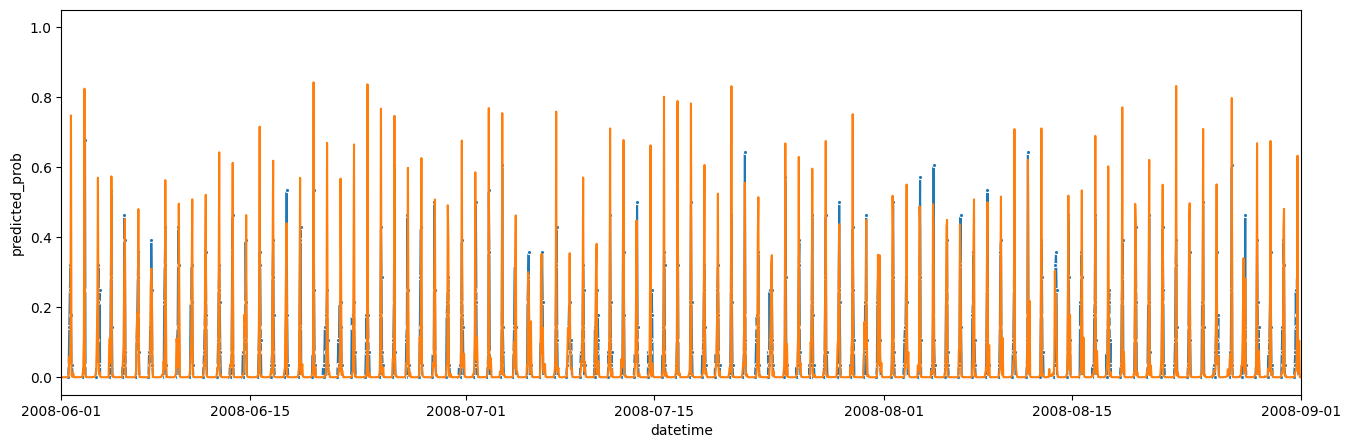

In [120]:
fig, ax = plt.subplots(figsize=(16, 5))
sns.lineplot(data=show_df, x="datetime", y="predicted_prob", marker=".", ax=ax)
sns.lineplot(data=show_df, x="datetime", y="daily_peak_probability", ax=ax)
ax.set_xlim([dt.datetime(2008, 6, 1), dt.datetime(2008, 9, 1)])

<Axes: xlabel='predicted_prob', ylabel='daily_peak_probability'>

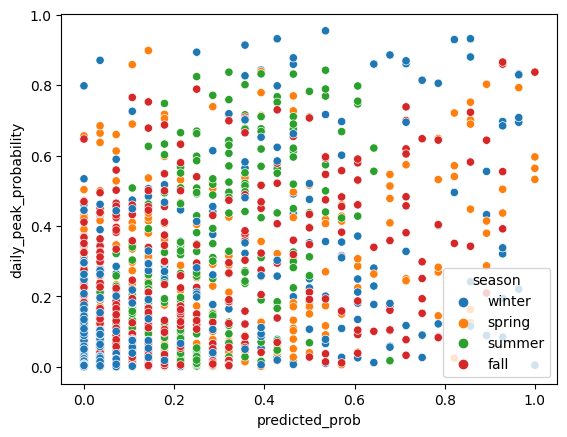

In [121]:
show_df["season"] = [season(int(d.month)) for d in show_df.date]
sns.scatterplot(
    data=show_df, x="predicted_prob", y="daily_peak_probability", hue="season"
)

In [113]:
show_df["predicted_prob"].corr(show_df["daily_peak_probability"])

0.679225660847809